<a href="https://colab.research.google.com/github/Above02/MC/blob/main/monte_carlo_hoop_strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo simulation of failure probability in mechanical design


This notebook contains an introduction to use of Python and the NumPy library for Monte Carlo simulation applied to a simple mechanical strength estimation, used for estimating failure probability. 

In [ ]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use("bmh")

## Problem statement

The hoop strength, or circumferential stress, to which a cylindrical vessel is exposed is given by the following equation:

$$\phi_H = \frac{P \cdot r}{W}$$

where:

- $P$ is the internal pressure in the vessel (a gauge pressure, expressed in MPa)
- $r$ is the inside radius of the pipe, expressed in mm
- $W$ is wall thickness, expressed in mm
- $\phi_H$ is expressed in MPa (million Pascals)

(This equation is only valid for “thin-walled” vessels, where $r$ is much larger than $t$.)

Pressure vessels and piping in petrochemical plants, and airplanes whose cabins are pressurized, can be thought of as thin-walled cylindrical vessels which must resist a certain level of internal pressure. Mechanical engineers will calculate the wall thickness required to resist a given internal pressure, then take a safety factor into account.

This type of analysis is a part of [stress-strain analysis](https://en.wikipedia.org/wiki/Stress%E2%80%93strain_analysis) in mechanical or civil engineering. This is used during system design to **check that a structure is safe** (that the strain on every component remains lower than the stress to which it will be exposed, plus a certain safety margin) and to **optimize the use of materials** (reduce the amount of materials used while remaining within the safety margin). For a detailed introduction to probabilistic techniques used in civil engineering, we recommend the [course notes](https://repository.tudelft.nl/islandora/object/uuid:e53b8dca-a0db-4433-b9f9-e190a507f99f?collection=research) *Probabilistic Design: Risk and Reliability Analysis in Civil Engineering* for a course at TUDelft.


We will make the following **assumptions** concerning the distribution of our input variables:

- pipe radius $r$ follows a normal distribution with a mean of 60 mm and coefficient of variation CV of 0.05 (5%)

- wall thickness $W$ follows a normal distribution with a mean of 4 mm and CV of 0.05

- the yield strength is also a random variable, following a normal distribution with a mean of 200 MPa and CV of 0.1 (yield strength is a property of a material; it’s the level of stress at which the material starts to deform plastically, or fail from a mechanical point of view)

- internal pressure in the vessel is assumed to be constant at 10 MPa

The [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) CV is a basic way of specifying uncertainty in a measurement; it’s defined as the ratio of the standard deviation by the mean:

$CV = \frac{\sigma}{\mu}$

We want to use a Monte Carlo simulation to estimate the probability of failure, which arises when the stress exceeds the yield strength of the vessel.

## Method 

Start by defining functions that generate simulated values for the stress and for the yield strength of the vessel.

In [ ]:
def simulated_stress():
    P = 10
    # note that given the definition of the coefficient of variation CV, the stdev is the mean times CV
    # ie sigma = mu * CV, here 60*0.05
    radius = scipy.stats.norm(60, 60*0.05).rvs()
    W = scipy.stats.norm(4, 4*0.05).rvs()
    return P * radius / W

def simulated_yield_strength():
    return scipy.stats.norm(200, 200*0.1).rvs()

Let’s run a Monte Carlo simulation to see how many times the stress exceeds the yield strength of the vessel, given our assumptions.

In [ ]:
N = 10_000
failures = 0
stresses = numpy.empty(N)
yield_strengths = numpy.empty(N)
for i in range(N):
    stresses[i] = simulated_stress()
    yield_strengths[i] = simulated_yield_strength()
    if stresses[i] > yield_strengths[i]:
        failures += 1

We can examine the **probability distributions** of the stress and the yield strength.

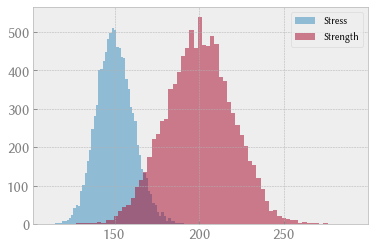

In [ ]:
plt.hist(stresses, alpha=0.5, label="Stress")
plt.hist(yield_strengths, alpha=0.5, label="Strength")
plt.legend(loc="upper right");

Note that the points where failure occurs are the intersection between the two histograms. We can estimate the probability of this failure thanks to the simulation we ran above.

In [ ]:
# the probability of failure
failures / float(N)

0.0138

## Aside on vectorization

Our code above uses for loops to run the simulation, which, in most programming languages, is the standard way of executing the same calculation a large number of times. However, the NumPy library offers the possibility of executing vector or **matrix arithmetic**, in which the same operation is executed on all matrix elements “simultaneously”. This allows you to write less verbose code which often executes more quickly on modern computers. For example:

In [ ]:
N = 10
ones = numpy.ones(N)
numpy.sqrt(ones + 3 * ones)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

On our hoop strength example, we could have written more compactly:

In [ ]:
N = 10_000
P = 10
radius = scipy.stats.norm(60, 60*0.05).rvs(N)
W = scipy.stats.norm(4, 4*0.05).rvs(N)
yield_strength = scipy.stats.norm(200, 200*0.1).rvs(N)
# sum() adds the items in the vector which are not False
((P * radius / W) > yield_strength).sum() / float(N)

0.0159

For a fantastic and very detailed document concerning vectorization in NumPy, see [From Python to NumPy](https://www.labri.fr/perso/nrougier/from-python-to-numpy/) by Nicolas Rougier (open access). 